# Quantitative Risk Management

Click <a href="https://colab.research.google.com/github/Lolillosky/QuantRiskManagement/blob/main/NOTEBOOKS/13_CDS_Calibration.ipynb">
    <img src="https://upload.wikimedia.org/wikipedia/commons/d/d0/Google_Colaboratory_SVG_Logo.svg" width="30" alt="Google Colab">
</a> to open this notebook in Google Colab.


In this exercise, you are going to bootstrap a zero coupon curve from par swap rates. After that, you will bootstrap a survival probability curve from CDS quotes.

## Import main libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Import the following libraries from the repository:

In [2]:
import sys
#sys.path.append('../CODE')  # Adjust the path as necessary


from IPython.display import clear_output


!rm -r {'QuantRiskManagement'}

!git clone https://github.com/Lolillosky/QuantRiskManagement.git

import sys
sys.modules.pop
sys.path.insert(0,'QuantRiskManagement/CODE')

clear_output()


In [3]:
import irs_exposure

In [4]:
num_sims = 10000

max_maturity = 10

num_step_year = 4

time_steps = np.linspace(0,max_maturity, num_step_year*max_maturity+1)

rates = np.zeros((num_sims, len(time_steps)))
NPVs = np.zeros((num_sims, len(time_steps)))


kappa = 0.1
sigma = 0.005
rate_0 = 0.01

HW = irs_exposure.HWModel(irs_exposure.FlatIRCurve(rate_0), kappa, sigma)
HWWrapp = irs_exposure.HWCurveWrapper(HW)

def_intensity = 0.01
recovery = 0.4

surv_prob = irs_exposure.SurvCurve(def_intensity).SurvProb(0,time_steps)
def_prob_time_step = surv_prob[0:-1]-surv_prob[1:]

rates[:,0] =  HW.get_rate(0,0)

irs_portfolio = irs_exposure.IRS_Portfolio([[1,irs_exposure.IRS(10,1,0.01)]])

NPVs[:,0] = irs_portfolio.get_NPV(0,HWWrapp)

curr_acc = np.zeros((num_sims, len(time_steps)))

curr_acc[:,0] = 1

for i in range(0, num_sims):

  x = 0
  HWWrapp.x = x

  curr_acc[:,1] = 1 / HWWrapp.DiscountFactor(0,time_steps[1])

  for j in range(1,num_step_year*max_maturity+1):

    x = HW.SimulProcess(time_steps[j-1], time_steps[j], x)

    rates[i,j] = HW.get_rate(time_steps[j], x)

    HWWrapp.x = x

    if j < num_step_year*max_maturity:
      curr_acc[i,j+1] = curr_acc[i,j] / HWWrapp.DiscountFactor(time_steps[j],time_steps[j+1])


    NPVs[i,j] = irs_portfolio.get_NPV(time_steps[j], HWWrapp)

mat = np.maximum(NPVs / curr_acc,0)
mat = (mat[:,0:-1]+mat[:,1:])/2

mat = mat*def_prob_time_step*(1-recovery)

interg = np.sum(mat, axis = 1)

test = np.cumsum(mat, axis = 1)

cva = np.mean(interg)

print('CVA: ' + str(cva))

CVA: 0.0006705943455549459


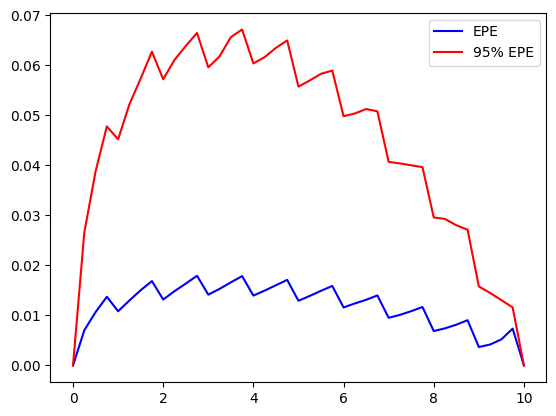

In [5]:
# plt.plot(time_steps, NPVs.T, 'grey', alpha = 0.1);

plt.plot(time_steps, np.mean(np.maximum(NPVs,0), axis = 0), 'blue', label = 'EPE');
plt.plot(time_steps, np.percentile(np.maximum(NPVs,0), axis = 0,q = 95), 'red', label = '95% EPE')

plt.legend();

plt.savefig('IRS_EPE_PFE.pdf')
